In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.dates

# Preprocess the data (explore, quality&coherency check)

In [331]:
#import driver data from csv
driver = pd.read_csv('driver_ids.csv')

driver['driver_onboard_date'] = pd.to_datetime(driver['driver_onboard_date']).dt.date
#check driver data basic summary 
driver.describe()


,driver_id,driver_onboard_date
count,937,937
unique,937,49
top,a85adc80be31a10c23b7aaf380e39173,2016-04-05
freq,1,36


In [332]:
#no missing values
driver.isnull().sum()

driver_id              0
driver_onboard_date    0
dtype: int64

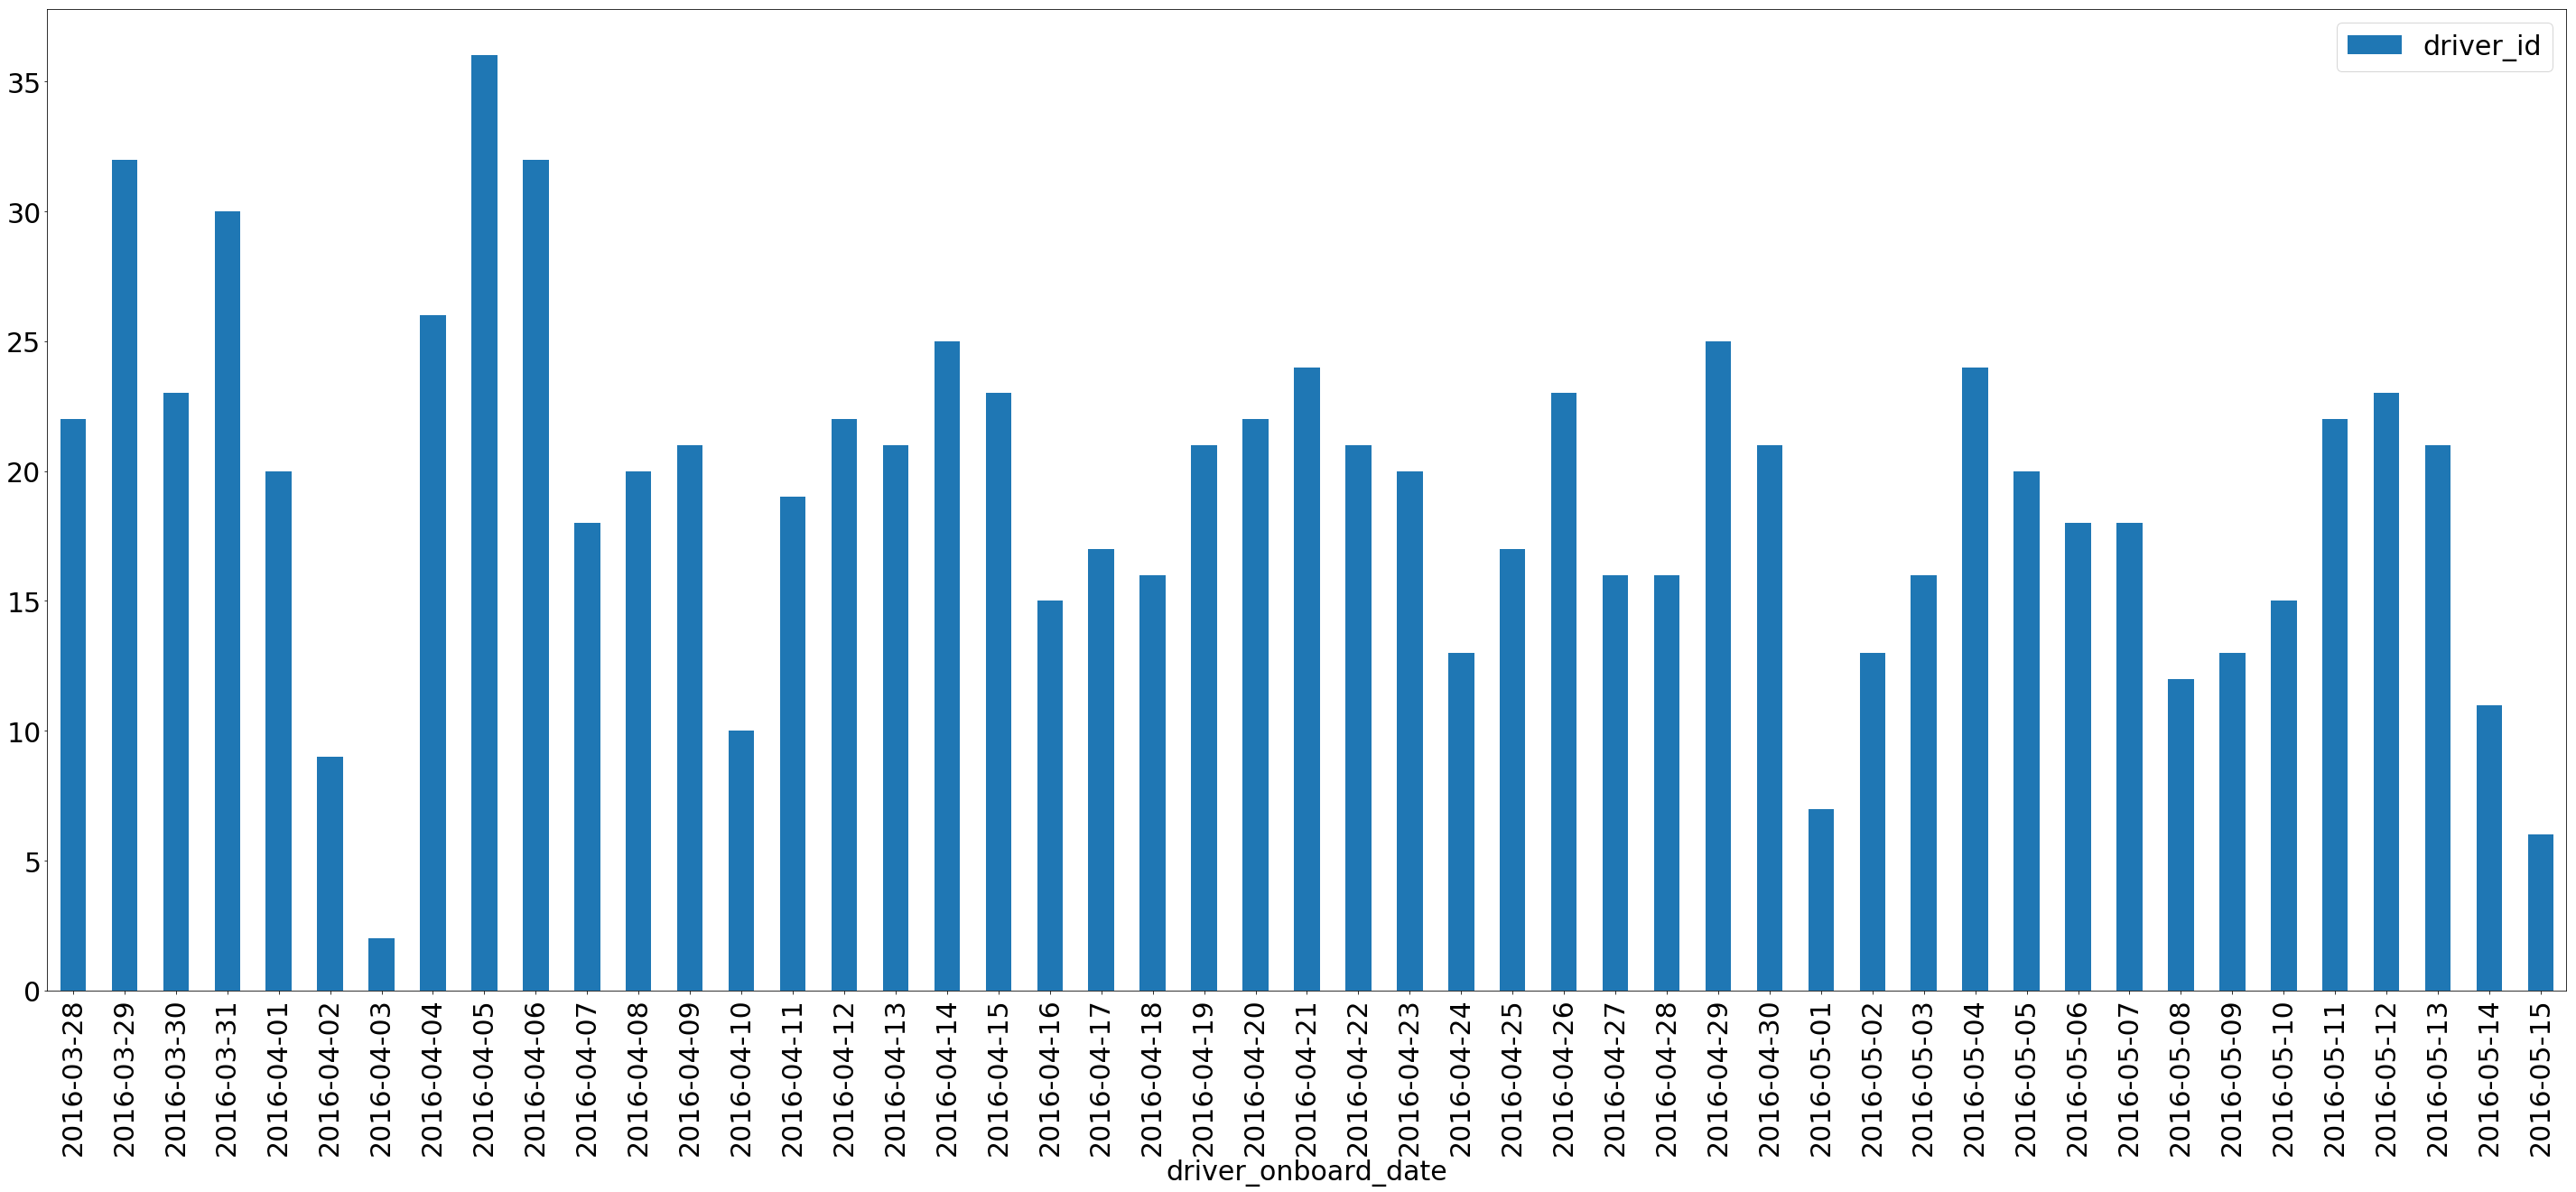

In [333]:
#look at driver onboard date distribution
plt.rcParams.update({'figure.figsize':[50,20], 'font.size':30})
driver.groupby(driver['driver_onboard_date']).count().plot(kind='bar')
plt.show()

The driver data sample contains drivers onboarded between 2016-03-28 to 2016-05-15, the distribution is fairly uniform with weekly cyclic pattern 

In [334]:
#import ride data and check summary
ride = pd.read_csv('ride_ids.csv')
ride.describe()

,ride_distance,ride_duration,ride_prime_time
count,193502.000000,193502.000000,193502.000000
mean,6955.218266,858.966099,17.305893
std,8929.444606,571.375818,30.825800
min,-2.000000,2.000000,0.000000
25%,2459.000000,491.000000,0.000000
50%,4015.000000,727.000000,0.000000
75%,7193.000000,1069.000000,25.000000
max,724679.000000,28204.000000,500.000000


There are records showing negative ride distance, it's probably due to data tracking error which need to be removed

In [335]:
#check missing value
ride.isnull().sum()

driver_id          0
ride_id            0
ride_distance      0
ride_duration      0
ride_prime_time    0
dtype: int64

In [336]:
#remove the records with negative ride distince 
ride = ride [ride['ride_distance']>0]
ride.describe()

,ride_distance,ride_duration,ride_prime_time
count,193315.000000,193315.000000,193315.000000
mean,6961.946290,859.633965,17.311254
std,8931.140532,571.122920,30.832015
min,1.000000,2.000000,0.000000
25%,2463.000000,492.000000,0.000000
50%,4020.000000,727.000000,0.000000
75%,7197.500000,1069.000000,25.000000
max,724679.000000,28204.000000,500.000000


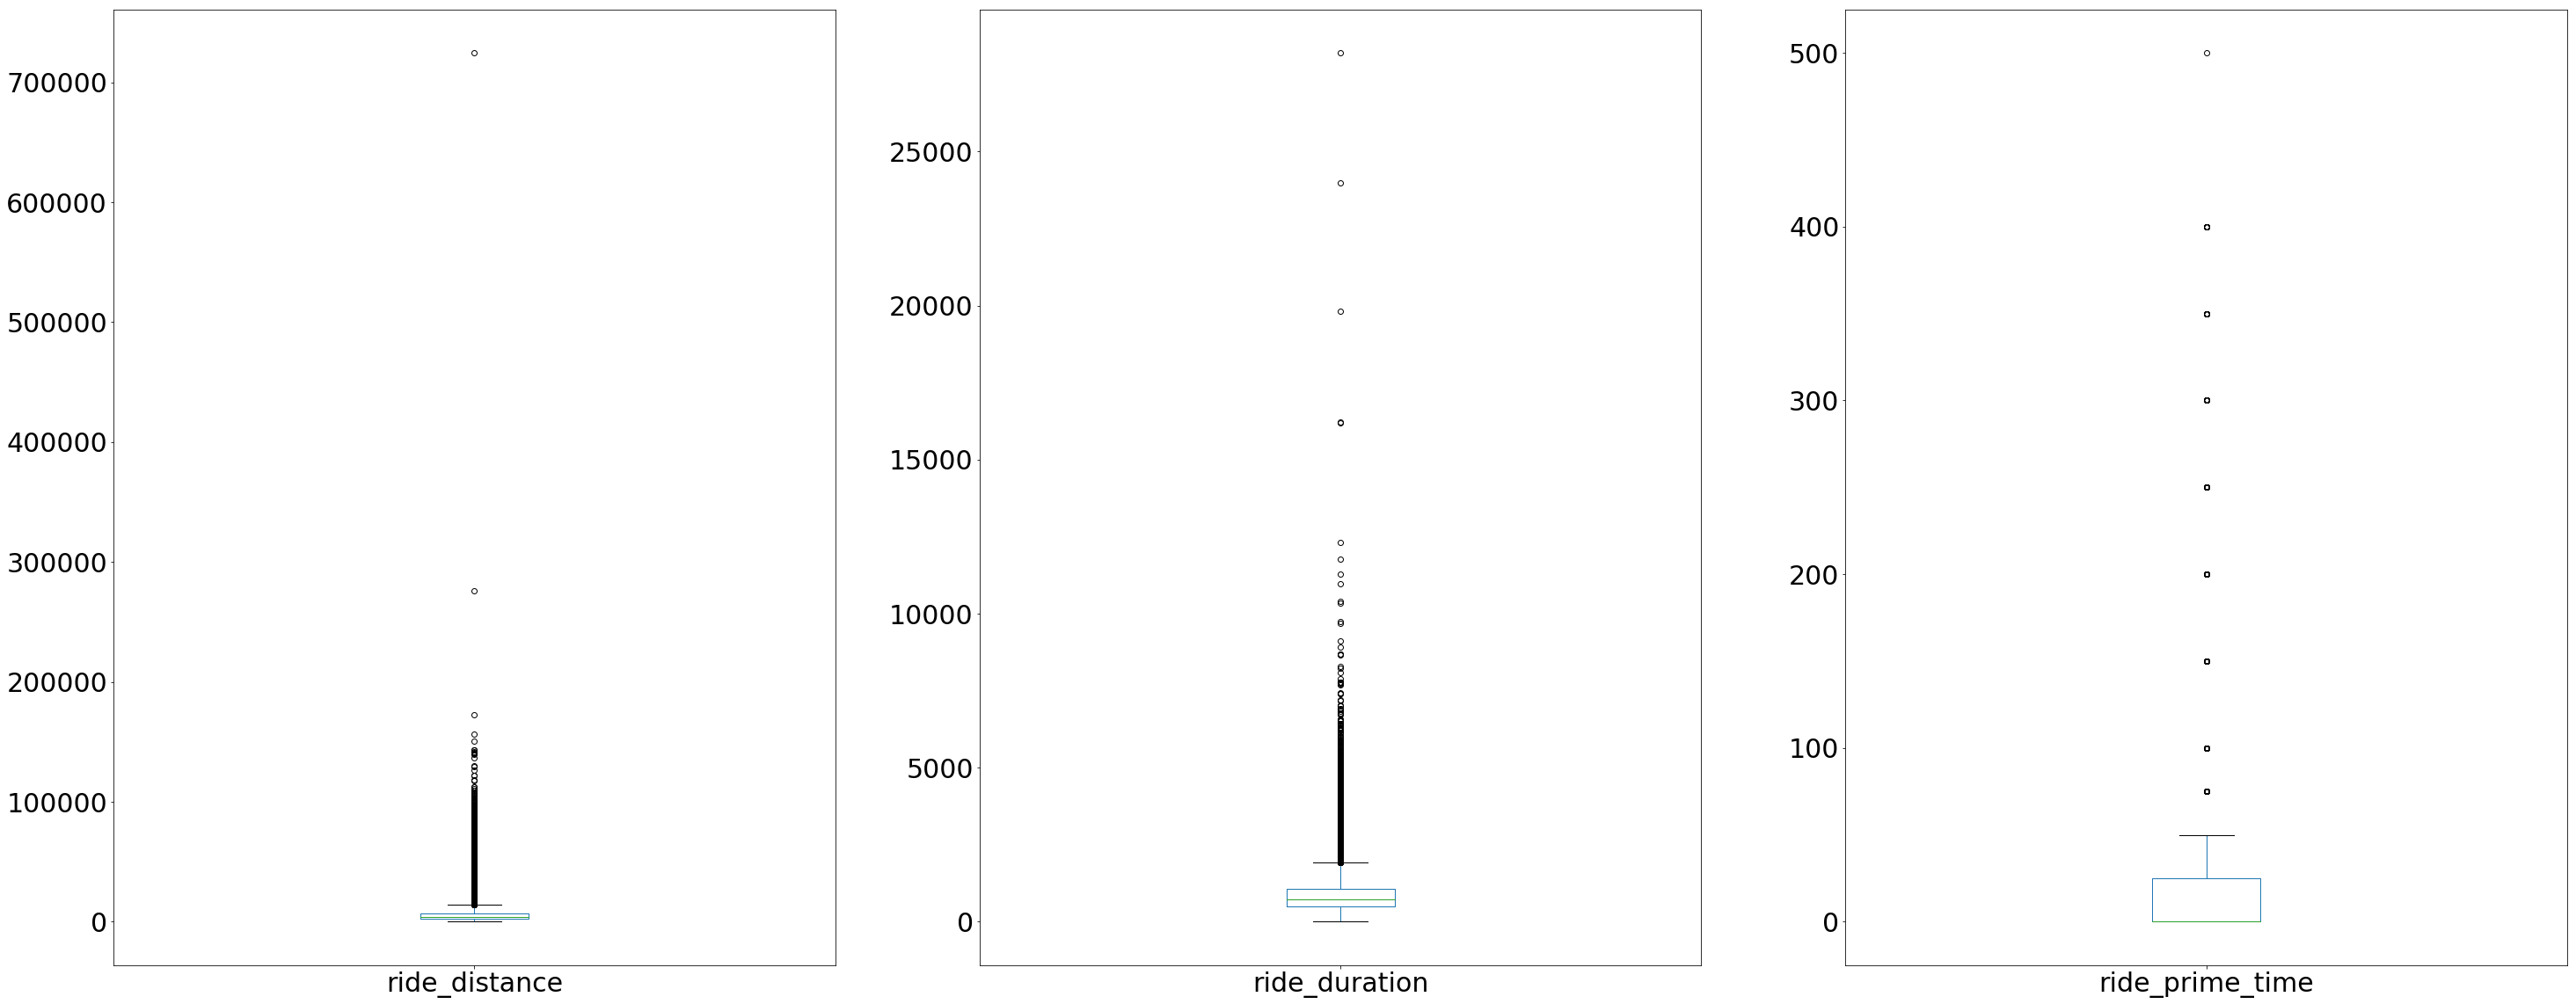

In [337]:
fig, (ax, ax1, ax2) = plt.subplots(ncols=3, sharey=False)

ride['ride_distance'].plot(kind="box", ax=ax)
ride['ride_duration'].plot(kind="box", ax=ax1)
ride['ride_prime_time'].plot(kind="box", ax=ax2)
plt.show()

In [338]:
#import ride ts data
ride_ts = pd.read_csv('ride_timestamps.csv')
ride_ts ['timestamp'] = pd.to_datetime(ride_ts ['timestamp'])
ride_ts.describe()

,ride_id,event,timestamp
count,970405,970405,970404
unique,194081,5,865826
top,51b44538f52ef231421b782e947b0b67,arrived_at,2016-04-30 22:09:15
freq,5,194081,7
first,NaN,NaN,2016-03-28 05:48:18
last,NaN,NaN,2016-06-27 00:50:50


In [339]:
#missing value? one timestamp is missing
ride_ts.isnull().sum()

ride_id      0
event        0
timestamp    1
dtype: int64

In [340]:
#what's the missing value
ride_ts[ride_ts.isnull().any(axis=1)]

,ride_id,event,timestamp
434222,72f0fa0bd86800e9da5c4dced32c8735,arrived_at,NaT


Since there is only one missing timestamp, we can do an imptation later to complete the data set

In [341]:
#data coherency check: to see if every ride has all 5 events
events_per_ride = ride_ts.groupby(['ride_id']).nunique()
events_per_ride.describe()

,ride_id,event,timestamp
count,194081.0,194081.0,194081.000000
mean,1.0,5.0,4.878391
std,0.0,0.0,0.329926
min,1.0,5.0,3.000000
25%,1.0,5.0,5.000000
50%,1.0,5.0,5.000000
75%,1.0,5.0,5.000000
max,1.0,5.0,5.000000


Event type is coherent, every ride has 5 unique events and no duplication in ride id

In [342]:
#pivot ride_ts table to make it convenient for future merging with ride data
ride_event = ride_ts.pivot(index='ride_id', columns='event', values='timestamp' )
ride_event.describe()

event,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at
count,194081,194080,194081,194081,194081
unique,190426,190526,190468,190524,190434
top,2016-06-02 16:00:22,2016-05-28 00:40:53,2016-06-03 18:59:26,2016-06-03 21:24:04,2016-05-06 20:39:08
freq,3,4,4,4,4
first,2016-03-28 05:48:23,2016-03-28 06:02:36,2016-03-28 06:37:51,2016-03-28 06:02:39,2016-03-28 05:48:18
last,2016-06-26 23:57:49,2016-06-27 00:02:03,2016-06-27 00:50:50,2016-06-27 00:02:06,2016-06-26 23:57:45


In [343]:
#fill the only missing value of arrive at timestamp based on the median of time difference from accept at to arrive at
ride_event['accpt_to_arrive'] = (ride_event['arrived_at']-ride_event['accepted_at']).astype('timedelta64[s]')
time_diff_mean = ride_event['accpt_to_arrive'].median()
ride_event.loc['72f0fa0bd86800e9da5c4dced32c8735','arrived_at']=ride_event.loc['72f0fa0bd86800e9da5c4dced32c8735','accepted_at'] + datetime.timedelta(0,time_diff_mean)
ride_event.loc['72f0fa0bd86800e9da5c4dced32c8735','accpt_to_arrive']=time_diff_mean

ride_event.loc['72f0fa0bd86800e9da5c4dced32c8735']

event
accepted_at        2016-04-20 11:57:20
arrived_at         2016-04-20 12:00:41
dropped_off_at     2016-04-20 12:16:30
picked_up_at       2016-04-20 12:02:20
requested_at       2016-04-20 11:56:50
accpt_to_arrive                    201
Name: 72f0fa0bd86800e9da5c4dced32c8735, dtype: object

In [344]:
#Data coherency check: is any ride that has earilier event's ts behind the later event, 
#i.e. accepted ts behind picked up ts
print(ride_event.query('accepted_at<requested_at').empty)
print(ride_event.query('arrived_at<accepted_at').empty)
print(ride_event.query('picked_up_at<arrived_at').empty)
print(ride_event.query('dropped_off_at<picked_up_at').empty)

True
True
False
True


Some rides have pick up event happened before arrive at event, let's see what they look like

In [345]:
pd.options.mode.chained_assignment = None  # default='warn'

In [346]:
#what are the typical time difference for these incoherent data?
ride_pu_b4_aa = ride_event[ride_event['picked_up_at']<ride_event['arrived_at']]
ride_pu_b4_aa['ts_diff'] = (ride_pu_b4_aa['picked_up_at'] - ride_pu_b4_aa['arrived_at']).astype('timedelta64[s]')
ride_pu_b4_aa['ts_diff'].value_counts()

-1.0       5905
-2.0       1616
-3.0        139
-5.0         12
-4.0         11
-11.0        10
-10.0        10
-6.0         10
-8.0         10
-237.0        6
-13.0         6
-189.0        6
-12.0         6
-14.0         6
-35.0         5
-38.0         5
-219.0        5
-7.0          5
-248.0        5
-15.0         5
-201.0        5
-92.0         5
-67.0         5
-78.0         5
-18.0         5
-208.0        4
-9.0          4
-306.0        4
-414.0        4
-90.0         4
           ... 
-1116.0       1
-996.0        1
-3476.0       1
-277.0        1
-397.0        1
-126.0        1
-478.0        1
-1008.0       1
-428.0        1
-809.0        1
-228.0        1
-783.0        1
-144.0        1
-672.0        1
-960.0        1
-352.0        1
-88.0         1
-72.0         1
-697.0        1
-281.0        1
-451.0        1
-683.0        1
-1169.0       1
-980.0        1
-892.0        1
-2676.0       1
-267.0        1
-519.0        1
-1061.0       1
-903.0        1
Name: ts_diff, Length: 4

Most of the difference between pick up and arrive at events are less than 10 seconds, it might be casued due to different system logs (i.e. arrived at ts and pick up ts are logged from separate driver and rider devices), in this case we are going to assume pick up happened at the same time of arrive at

In [355]:
#impute the timestamp of pick up to the same as arrive at timestamp for thoes rides have pick up happend 
#before arrive at
ride_event.head()

for index, row in ride_event.iterrows():
    if row['picked_up_at'][str(index)] < row['arrived_at'][str(index)]:
        row['picked_up_at'][str(index)] = row['arrived_at'][str(index)]


TypeError: 'Timestamp' object has no attribute '__getitem__'

In [349]:
#event time stamp data looks coherent now
print(ride_event.query('accepted_at<requested_at').empty)
print(ride_event.query('arrived_at<accepted_at').empty)
print(ride_event.query('picked_up_at<arrived_at').empty)
print(ride_event.query('dropped_off_at<picked_up_at').empty)

True
True
False
True


# Process the data, create a universal driver-ride table 

In [329]:
#merge ride data with ride event data
#I chose inner join here b/c we need the complete data of a ride, if the ride only has event info 
#but no duration/distince info, it cannot associate with the according drider id
# if the ride only has duration/distance info but no event info, we cannot tell when the ride happened
#thus it won't be possible to calculate driver's life time
ride_event.reset_index(inplace=True)
all_rides = pd.merge(ride,ride_event,how='inner', left_on='ride_id', right_on='ride_id')


ValueError: cannot insert level_0, already exists

In [328]:
#merge all rides data with driver data
#I chose outer join here since we need to keep the drivers even though they don't have rides, it's very likely that
#then just signed up but never drove with Lyft, on the other hand I decided to keep the rides that cannot find driver 
#id in driver table, the only missing information here is the onboard date, and there are only 7 drivers fall in this
#case, we can impute it with mean value later
driver_ride = all_rides = pd.merge(driver,all_rides,how='outer', left_on='driver_id', right_on='driver_id')

#find how many drivers that has rides data but cannot find onboard date
driver_ride[driver_ride['driver_onboard_date'].isnull()].nunique()

driver_id                  7
driver_onboard_date        0
driver_onboard_date_x      0
driver_onboard_date_y      0
driver_onboard_date_x      0
driver_onboard_date_y      0
driver_onboard_date_x      0
driver_onboard_date_y      0
ride_id                  609
ride_distance            587
ride_duration            508
ride_prime_time            7
level_0                  609
index                    609
accepted_at              609
arrived_at               609
dropped_off_at           609
picked_up_at             609
requested_at             609
accpt_to_arrive          326
dtype: int64

# Determine how to define churn behavior

    avg_interval_in_days  driver_cnt  cum_percent
0                    1.0         294    34.834123
1                    2.0         286    68.720379
2                    3.0          88    79.146919
3                    4.0          55    85.663507
4                    5.0          34    89.691943
5                    6.0          39    94.312796
6                    7.0          15    96.090047
7                    8.0          13    97.630332
8                    9.0           3    97.985782
9                   10.0           4    98.459716
10                  11.0           1    98.578199
11                  12.0           1    98.696682
12                  13.0           5    99.289100
13                  14.0           3    99.644550
14                  18.0           1    99.763033
15                  20.0           1    99.881517
16                  56.0           1   100.000000


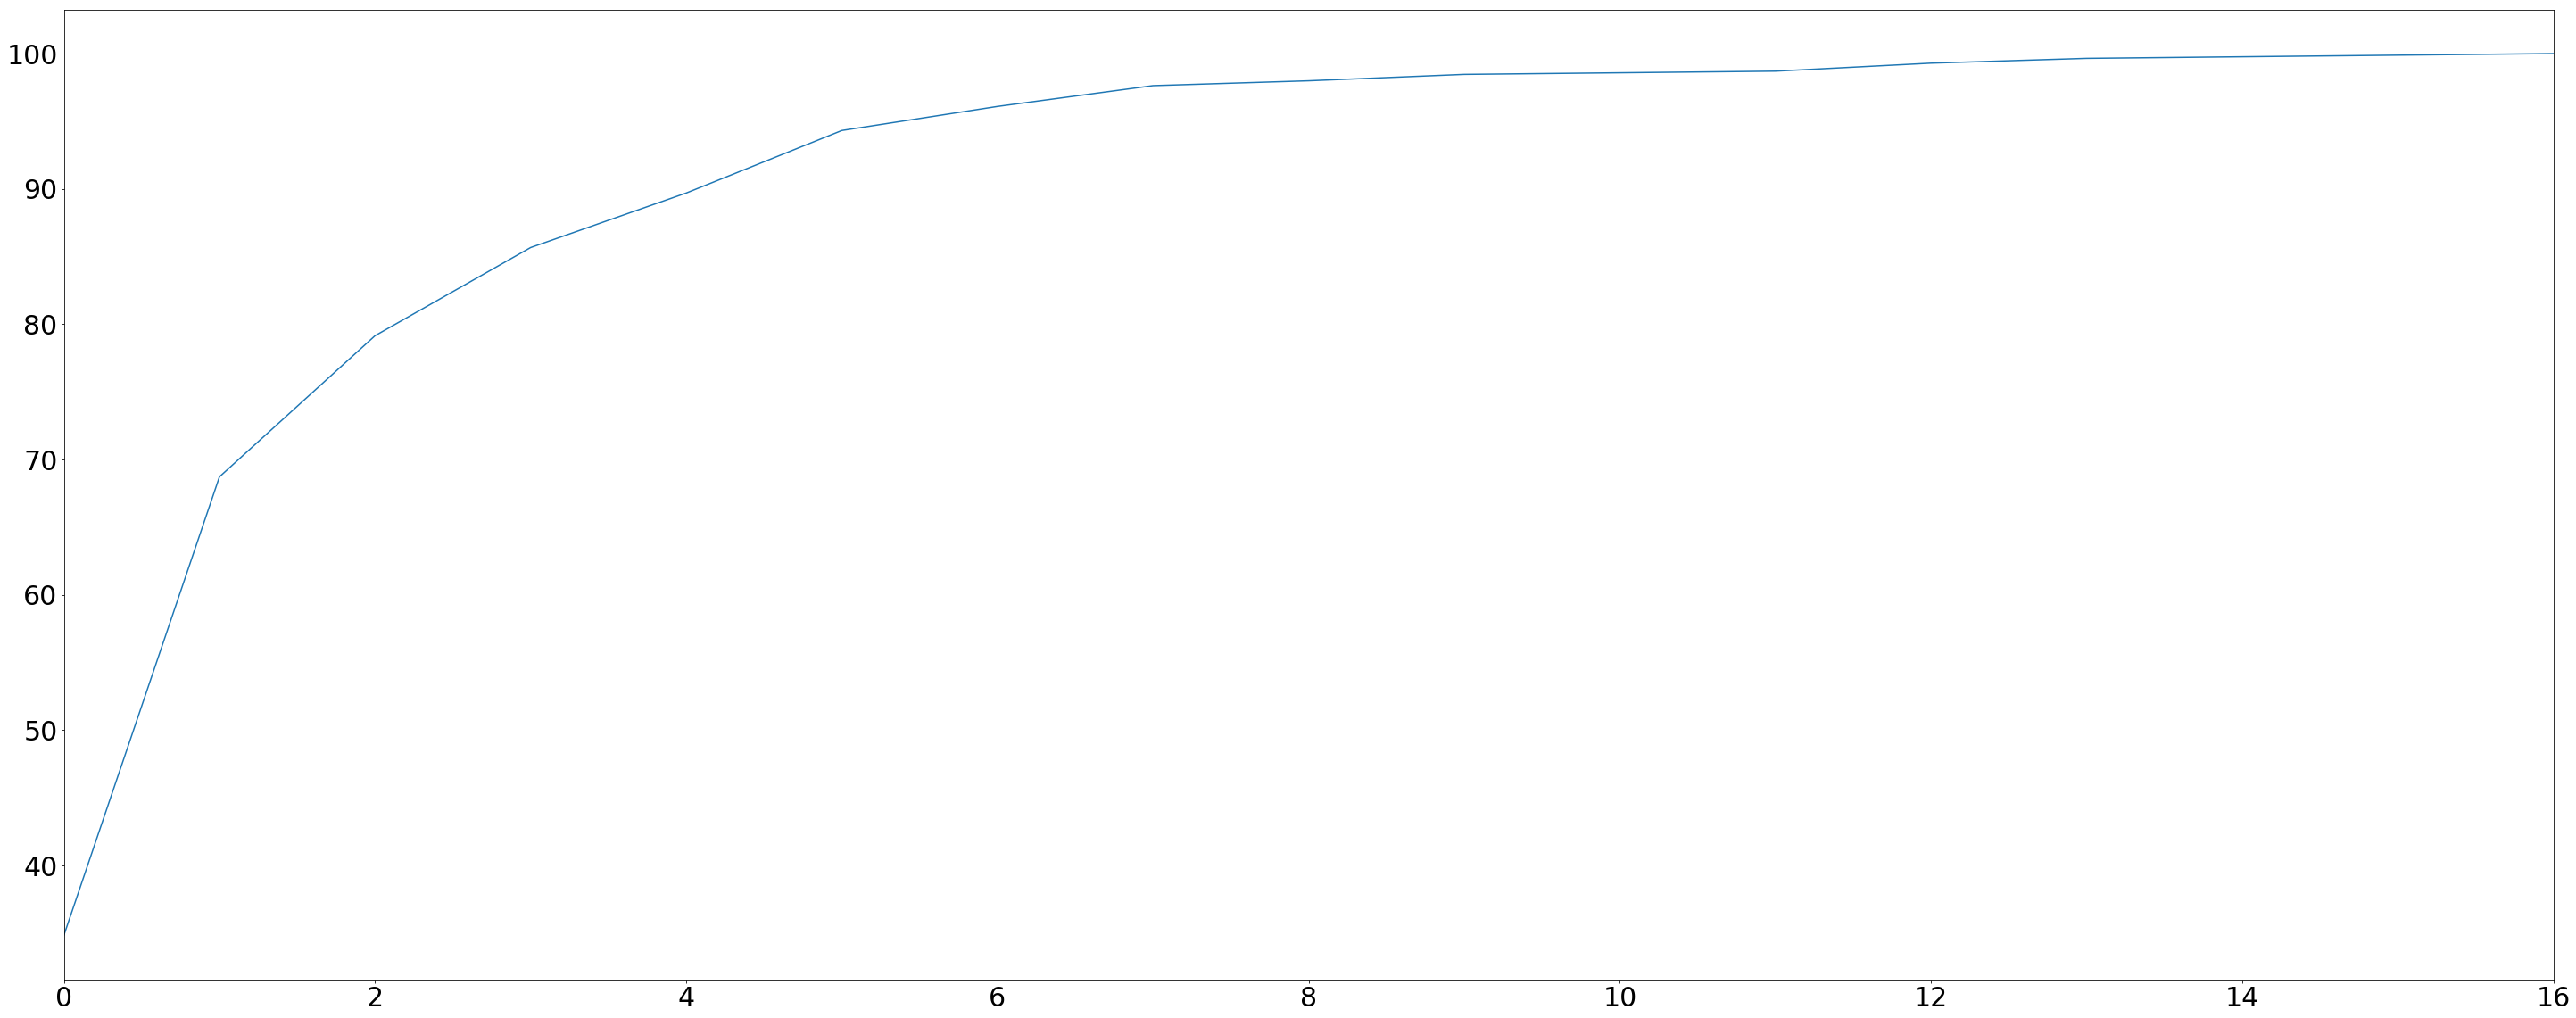

In [312]:
#Because driver's lifetime is defined as the time period they continue driving with Lyft before churning out,
#at first we need to understand how we define a driver has churned, the question I'm trying to answer here is after
#observing how many days a driver has been inactive, we can confidently say this driver is highly likely churned

#Methodoloy:
#Take observation of the time intervals between driver's active days with Lyft (active day defined as they have at 
#least one ride on a given day), this represents the frequency of an active driver's replationship with Lyft. 
#From the below data, you will find >95% of the active drivers wouldn't stay inactive more than 7 consecutive days, 
#so we can assume that any driver hasn't been driving with Lfyt for more than 7 days should be considered as churned

#Prepare the data
ride_interval = pd.DataFrame()
ride_interval['driver_id'] = driver_ride['driver_id']
ride_interval['ride_dt'] = driver_ride['accepted_at'].dt.date

ride_interval.drop_duplicates(inplace=True)
ride_interval.sort_values(by=['driver_id','ride_dt'], ascending=True, inplace=True)

#calculate the average of consecutive inactive days for each active driver
ride_interval['ride_dt_lag'] = ride_interval.groupby(['driver_id'])['ride_dt'].shift(1)
ride_interval['ride_time_interval'] = ride_interval['ride_dt']-ride_interval['ride_dt_lag']
ride_interval.fillna(datetime.timedelta(0,0),inplace=True)
ride_interval['ride_time_interval']= (ride_interval['ride_time_interval']/np.timedelta64(1, 'D')).astype(int)
ride_interval.replace(0,np.nan, inplace=True)


driver_interval_max = ride_interval.groupby(['driver_id']).max().reset_index().dropna()
driver_interval_max['interval_bin'] = driver_interval_max['ride_time_interval'].round()
#Plot the distribution of time inverval between active rides
driver_max_interval_dist=pd.DataFrame()
driver_max_interval_dist[['max_interval_in_days','driver_cnt']] = driver_interval_max.groupby(['interval_bin']).count().reset_index()[['interval_bin','driver_id']]
driver_max_interval_dist['cum_percent'] = driver_max_interval_dist['driver_cnt'].cumsum()/driver_time_interval_dist['driver_cnt'].sum()*100.0
driver_max_interval_dist

print(driver_max_interval_dist)
driver_max_interval_dist['cum_percent'].plot(kind='line')
plt.show()

    max_interval_in_days  driver_cnt  cum_percent
0                    1.0          14     1.658768
1                    2.0          47     7.227488
2                    3.0          70    15.521327
3                    4.0          66    23.341232
4                    5.0          82    33.056872
5                    6.0          69    41.232227
6                    7.0          73    49.881517
7                    8.0          48    55.568720
8                    9.0          45    60.900474
9                   10.0          30    64.454976
10                  11.0          27    67.654028
11                  12.0          32    71.445498
12                  13.0          18    73.578199
13                  14.0          19    75.829384
14                  15.0          25    78.791469
15                  16.0          20    81.161137
16                  17.0          12    82.582938
17                  18.0          16    84.478673
18                  19.0           9    85.545024


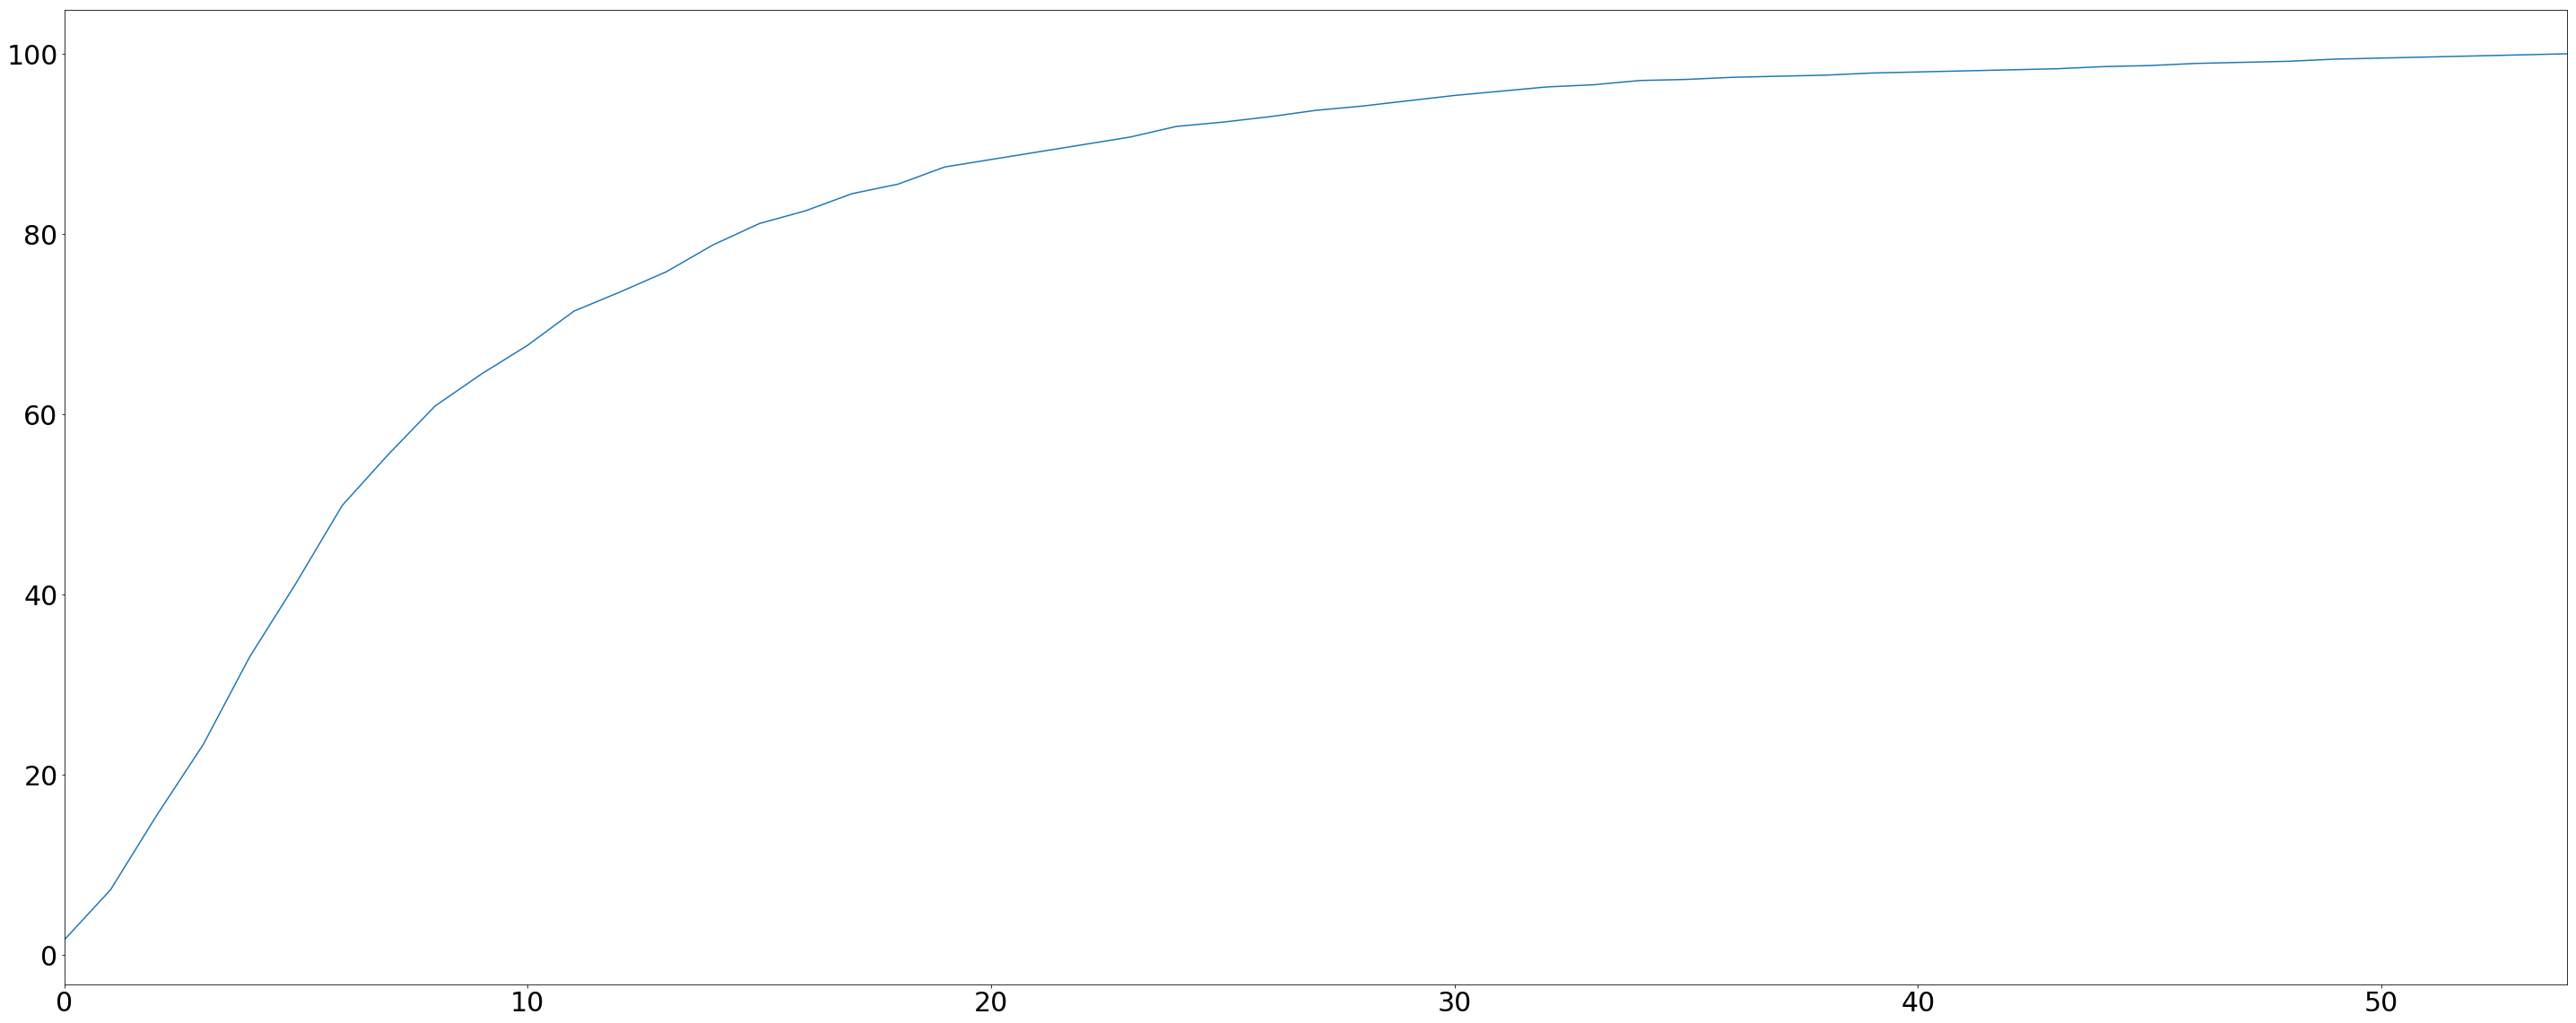

In [320]:
driver_interval_max = ride_interval.groupby(['driver_id']).max().reset_index().dropna()
driver_interval_max['interval_bin'] = driver_interval_max['ride_time_interval'].round()
#Plot the distribution of time inverval between active rides
driver_max_interval_dist=pd.DataFrame()
driver_max_interval_dist[['max_interval_in_days','driver_cnt']] = driver_interval_max.groupby(['interval_bin']).count().reset_index()[['interval_bin','driver_id']]
driver_max_interval_dist['cum_percent'] = driver_max_interval_dist['driver_cnt'].cumsum()/driver_time_interval_dist['driver_cnt'].sum()*100.0
driver_max_interval_dist

print(driver_max_interval_dist)
driver_max_interval_dist['cum_percent'].plot(kind='line')
plt.show()

# Discover drivers' churn behavior and their lifetime distribution

In [313]:
ride_interval.head(100)

,driver_id,ride_dt,ride_dt_lag,ride_time_interval
1,002be0ffdc997bd5c50703158b7c2491,2016-03-29,0:00:00,NaN
20,002be0ffdc997bd5c50703158b7c2491,2016-03-31,2016-03-29,2.0
7,002be0ffdc997bd5c50703158b7c2491,2016-04-01,2016-03-31,1.0
30,002be0ffdc997bd5c50703158b7c2491,2016-04-02,2016-04-01,1.0
25,002be0ffdc997bd5c50703158b7c2491,2016-04-05,2016-04-02,3.0
153,002be0ffdc997bd5c50703158b7c2491,2016-04-07,2016-04-05,2.0
21,002be0ffdc997bd5c50703158b7c2491,2016-04-09,2016-04-07,2.0
194,002be0ffdc997bd5c50703158b7c2491,2016-04-10,2016-04-09,1.0
105,002be0ffdc997bd5c50703158b7c2491,2016-04-11,2016-04-10,1.0
12,002be0ffdc997bd5c50703158b7c2491,2016-04-12,2016-04-11,1.0


In [13]:
#use drop off ts as the completion time
ride_cmplt_ts = ride_ts[ride_ts['event']=='dropped_off_at']
ride_cmplt_ts.describe(

,ride_id,event,timestamp
count,194081,194081,194081
unique,194081,1,190468
top,51b44538f52ef231421b782e947b0b67,dropped_off_at,2016-06-03 18:59:26
freq,1,194081,4


In [25]:
ride = pd.read_csv('ride_ids.csv')

driver_ride = pd.merge(driver, ride, how= 'outer', left_on='driver_id', right_on='driver_id')

#driver_ride.isnull().sum()


driver_id                 0
driver_onboard_date    7611
ride_id                  83
ride_distance            83
ride_duration            83
ride_prime_time          83
dtype: int64